In [1]:
# Check if python is 3.9.5
import sys
print(sys.version)
%load_ext autoreload
%autoreload 2

3.9.5 (default, May 18 2021, 12:31:01) 
[Clang 10.0.0 ]


## Code questions

<div class="alert alert-block alert-warning">
    <b>When do I use <span style="font-family: Monospace; background-color: #FFFFE0">abc.ABC</span> as superclass and when <span style="font-family: Monospace; background-color: #FFFFE0"> abc.ABCMeta</span> as metaclass? </b> <br>
    <a href="https://docs.python.org/3/library/abc.html">Here</a> is the <span style="font-family: Monospace; background-color: #FFFFE0">abc</span> package.
</div>

# Data mining

In [7]:
import multidb_wrapper
import database_classes

In [3]:
naip = utils.NAIPData()

In [4]:
naip.get_data()
database_classes

NAIP


In [2]:
import tempfile
import urllib
import shutil
import os

import matplotlib.pyplot as plt
import numpy as np
import rasterio
import re
import rtree
import shapely
import pickle

from geopy.geocoders import Nominatim
from rasterio.windows import Window 

latest_wkid = 3857
crs = 'EPSG:4326'

# The (preferred) copy of NAIP in the West Europe Azure region
blob_root = 'https://naipeuwest.blob.core.windows.net/naip'

# NAIP is also available in the East US Azure region
# blob_root = 'https://naipblobs.blob.core.windows.net/naip'

# We maintain a spatial index of NAIP tiles using the [rtree](https://pypi.org/project/Rtree/) library
index_files = ['tile_index.dat', 'tile_index.idx', 'tiles.p']
index_blob_root = re.sub('/naip$','/naip-index/rtree/',blob_root)
temp_dir = os.path.join(tempfile.gettempdir(),'naip')
os.makedirs(temp_dir,exist_ok=True)

# Spatial index that maps lat/lon to NAIP tiles; we'll load this when we first 
# need to access it.
index = None

# URL where we've stashed a geojson file with the boundaries of Maryland.  Why do we
# need the boundaries of Maryland?  It's a surprise, you'll have to keep reading to find
# out.
maryland_boundary_url = 'https://ai4edatasetspublicassets.blob.core.windows.net/assets/maryland.json'

# NAIP tiles are enormous; downsize for plotting in this notebook
dsfactor = 10

In [3]:
def download_url(url,destination_filename=None):
    """
    Download a URL to a temporary file
    """
    
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')    
        destination_filename = os.path.join(temp_dir,url_as_filename)    
    urllib.request.urlretrieve(url, destination_filename)  
    return destination_filename


def display_naip_tile(filename):
    """
    Display a NAIP tile using rasterio.
    """
    
    with rasterio.open(filename) as raster:

        # NAIP imagery has four channels: R, G, B, IR
        #
        # Stack RGB channels into an image; we won't try to render the IR channel
        #
        # rasterio uses 1-based indexing for channels.
        h = int(raster.height/dsfactor)
        w = int(raster.width/dsfactor)
        r = raster.read(1, out_shape=(1, h, w))
        g = raster.read(2, out_shape=(1, h, w))
        b = raster.read(3, out_shape=(1, h, w))        
    
    rgb = np.dstack((r,g,b))
    
    fig = plt.figure(frameon=False); ax = plt.Axes(fig,[0., 0., 1., 1.]); 
    ax.set_axis_off(); fig.add_axes(ax)

    plt.imshow(rgb);
    raster.close()


def get_coordinates_from_address(address):
    """
    Look up the lat/lon coordinates for an address.
    """
    
    geolocator = Nominatim(user_agent="NAIP")
    location = geolocator.geocode(address)
    print('Retrieving location for address:\n{}'.format(location.address))
    return location.latitude, location.longitude

In [4]:
lat = 47.645950
lon = -118.136980

In [16]:
fl = index_blob_root + file_path
urllib.request.urlretrieve(fl)

('/var/folders/h_/fp7vzm1s46x0fbjfhmjqmlsc0000gn/T/tmptsrxegij',
 <http.client.HTTPMessage at 0x7ff541cb9130>)

In [ ]:
tile_rtree = None
tile_index = None
base_path = None

if base_path is None:
    base_path = temp_dir
    os.makedirs(base_path, exist_ok=True)
    for file_path in index_files:
        print(index_blob_root + file_path)
        download_url(index_blob_root + file_path, base_path + '/' + file_path)

base_path = base_path
tile_rtree = rtree.index.Index(base_path + "/tile_index")
tile_index = pickle.load(open(base_path  + "/tiles.p", "rb"))
#######################


https://naipeuwest.blob.core.windows.net/naip-index/rtree/tile_index.dat
https://naipeuwest.blob.core.windows.net/naip-index/rtree/tile_index.idx
https://naipeuwest.blob.core.windows.net/naip-index/rtree/tiles.p


In [12]:

point = shapely.geometry.Point(float(lon),float(lat))
intersected_indices = list(tile_rtree.intersection(point.bounds))

intersected_files = []
tile_intersection = False

for idx in intersected_indices:

    intersected_file = tile_index[idx][0]
    intersected_geom = tile_index[idx][1]
    if intersected_geom.contains(point):
        tile_intersection = True
        intersected_files.append(intersected_file)

if not tile_intersection and len(intersected_indices) > 0:
    print('''Error: there are overlaps with tile index, 
              but no tile completely contains selection''')   
elif len(intersected_files) <= 0:
    print("No tile intersections")
else:
    print( intersected_files )

['v002/wa/2017/wa_100cm_2017/47118/m_4711823_se_11_1_20170717.tif', 'v002/wa/2011/wa_100cm_2011/47118/m_4711823_se_11_1_20110702.tif', 'v002/wa/2013/wa_100cm_2013/47118/m_4711823_se_11_1_20130628.tif', 'v002/wa/2015/wa_100cm_2015/47118/m_4711823_se_11_1_20150702.tif', 'v002/wa/2019/wa_60cm_2019/47118/m_4711823_se_11_060_20190726.tif']


## NAIP

<div class="alert alert-block alert-danger">
    <b>What exactly is this <a href="https://planetarycomputer.microsoft.com/dataset/naip#Blob-Storage-Notebook">Azure blob storage</a>?</b> <br> It seems, as if it does not need authentication, but we would, if we used <a href="https://planetarycomputer.microsoft.com/dataset/naip#Example-Notebook">Planetary Computer STAC API</a> by Microsoft or even Google's <a href="https://developers.google.com/earth-engine/datasets/catalog/USDA_NAIP_DOQQ#description">Earth Engine Data Catalog</a>. Where is the caveat? 
</div>

In [6]:
multidb_wrapper.set_directory("aa")

'aa/data_barrel'

In [20]:
multidb_wrapper.set_locations([1,2,2,3], [2,3,4])

AssertionError: The lists for latitudes ({len(longitudes)}) and lon (4) have unequal length. Please adjust.

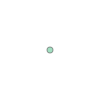

In [18]:
import shapely
shapely.geometry.point.Point(1,2)